In [110]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

在这个模型中，通过正弦序列中的连续num_time_steps个点预测下一个点。
先产生一个num_x_points，即50个点的正弦序列。然后用这个正弦序列生成训练数据。
训练数据包含50-10=40个序列。
第一个序列：输入为第1-10个点的正弦值，输出target为第11个点的正弦值。
第二个序列：输入为第2-11个点的正弦值，输出target为第12个点的正弦值。
以此类推。
注意，这里RNN中，只用到最右边一个输出，即最后一个timestep单元对应的hidden状态，然后通过线性变换生成输出。

另外还有一个程序，是另一种方式，例如，通过第1-10个点，预测2-11个点。
这时，RNN的所有timestep单元对应的hidden状态都要用于生成output。

In [111]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import numpy as np
import torch

In [112]:
input_size = 1
hidden_size = 16
output_size = 1
num_time_steps = 10
num_x_points = 50
batch_size = 8
num_epochs = 20

#这个代码块是不用了的。
x = np.linspace(-2*np.pi,2*np.pi,400)
y = np.sin(x)
#print(x)
print(x.shape)
print(y.shape)

#这个代码块也不用了。
X = np.expand_dims(x,axis=1)
Y = y.reshape(400,-1)
print(X.shape)
print(Y.shape)

In [113]:
x_points = np.linspace(-2*np.pi,2*np.pi,num_x_points)
sin_sequence = np.sin(x_points)
print(sin_sequence.shape)

(50,)


def generate_data(seq):
    X = []
    Y = []
    for i in range(len(seq)-num_time_steps):
        X.append([seq[i:i + num_time_steps]])
        Y.append([seq[i + num_time_steps]])
    return X,Y

[X,Y] = generate_data(sin_sequence)
print(X)
print(len(X))
print(type(X[1][0]))
print(X[1][0].shape)
print(Y)
print(len(Y))

In [114]:
def generate_data(seq):
    X = []
    y = []
    for i in range(len(seq)-num_time_steps):
        X.append([seq[i:i + num_time_steps]])
        y.append([seq[i + num_time_steps]])
    return np.array(X,dtype=np.float32),np.array(y,dtype=np.float32)

In [115]:
[X,y] = generate_data(sin_sequence)
#print(X)
print(X.shape)  #(40,1,10)
X = X.transpose(0,2,1)   #transpose与reshape区别？
print(X.shape)
#print(y)
print(y.shape)  #(40,1)

(40, 1, 10)
(40, 10, 1)
(40, 1)


In [116]:
dataset = TensorDataset(torch.tensor(X,dtype=torch.float),torch.tensor(y,dtype=torch.float))

In [117]:
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
type(dataloader)

torch.utils.data.dataloader.DataLoader

nn.RNN, RNNBase,RNNcell,RNNcellbase有什么区别？
什么时候网络结构要设计派生类？

In [118]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.liner = nn.Linear(hidden_size,output_size)
        
    def forward(self,x,h0):
        out,hn = self.rnn(x,h0)  
        #now out: (batch_size,seq_length,hidden_size)
        #hn: (1,batch_size,hidden_size)
        #print(out.shape)
        #print('hn shape:{}'.format(hn.shape))
        out = out[:,-1,:]
        out = out.view(-1,hidden_size) #out.view(batch_size,hidden_size)
        #print(out.shape)
        out = self.liner(out)
        #print(out.shape)
        return out,hn

In [119]:
model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),1e-2)

h0 = torch.zeros(1,batch_size,hidden_size)

In [120]:
for epoch in range(num_epochs):
    for batch_x,batch_y in dataloader:
        #print(batch_x.shape)
        #print('batch_y shape:{}'.format(batch_y.shape))
        (y_predict,hn) = model(batch_x,h0)
        #print('y_predict shape:{}'.format(y_predict.shape))
        loss = criterion(y_predict,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch:{}, loss:{}'.format(epoch+1,loss.item()))

epoch:1, loss:0.2970317602157593
epoch:2, loss:0.19924497604370117
epoch:3, loss:0.11399070173501968
epoch:4, loss:0.0030341388192027807
epoch:5, loss:0.028286049142479897
epoch:6, loss:0.011129038408398628
epoch:7, loss:0.015432802960276604
epoch:8, loss:0.017301617190241814
epoch:9, loss:0.005960273556411266
epoch:10, loss:0.002924890024587512
epoch:11, loss:0.00309054390527308
epoch:12, loss:0.0017144476296380162
epoch:13, loss:0.00034147509722970426
epoch:14, loss:0.00029292324325069785
epoch:15, loss:0.000857775507029146
epoch:16, loss:0.0009925049962475896
epoch:17, loss:0.00021697489137295634
epoch:18, loss:0.00017447737627662718
epoch:19, loss:0.00024913225206546485
epoch:20, loss:0.00020701873290818185


下面是测试部分。

In [124]:
scale_factor = 5
test_points = np.linspace(-2*np.pi*scale_factor,2*np.pi*scale_factor,num_x_points*scale_factor)  #是不是测试与训练要时间间隔相等啊？
test_x_true = np.sin(test_points)
print(test_x_true.shape)

(250,)


In [125]:
model.eval()  #前面没加model.train()？
h0 = torch.zeros(1,1,hidden_size)
prediction = test_x_true[:10].tolist()
#print(prediction)
#cur_input = torch.tensor(test_x_true[:10])  #这里大写和小写的tensor有什么区别？
#cur_input = cur_input.reshape(1,10,1)
#print(cur_input.shape)

for i in range(num_x_points*scale_factor-num_time_steps):
    cur_input = prediction[i:i+10]
    cur_input = torch.tensor(cur_input).reshape(1,10,1)
    (y_pred, hn) = model(cur_input,h0)
    #print(y_pred.shape)
    prediction.append(y_pred[0,0])
    
print(prediction) 
print(len(prediction))
    

Net(
  (rnn): RNN(1, 16, batch_first=True)
  (liner): Linear(in_features=16, out_features=1, bias=True)
)

[1.2246467991473533e-15, 0.2496673968626087, 0.48352168639969956, 0.6867513112135009, 0.8464843789012085, 0.9526039251554224, 0.9983886888289514, 0.9809388143902326, 0.9013595191835575, 0.7646910926171744, tensor(0.5621, grad_fn=<SelectBackward>), tensor(0.3477, grad_fn=<SelectBackward>), tensor(0.1116, grad_fn=<SelectBackward>), tensor(-0.1309, grad_fn=<SelectBackward>), tensor(-0.3692, grad_fn=<SelectBackward>), tensor(-0.5877, grad_fn=<SelectBackward>), tensor(-0.7686, grad_fn=<SelectBackward>), tensor(-0.8961, grad_fn=<SelectBackward>), tensor(-0.9575, grad_fn=<SelectBackward>), tensor(-0.9488, grad_fn=<SelectBackward>), tensor(-0.8754, grad_fn=<SelectBackward>), tensor(-0.7476, grad_fn=<SelectBackward>), tensor(-0.5743, grad_fn=<SelectBackward>), tensor(-0.3620, grad_fn=<SelectBackward>), tensor(-0.1195, grad_fn=<SelectBackward>), tensor(0.1379, grad_fn=<SelectBackward>), tensor(0.3875, grad_fn=<SelectBackward>), tensor(0.6074, grad_fn=<SelectBackward>), tensor(0.7839, grad_fn=<Se

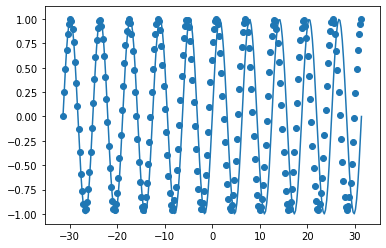

In [126]:
import matplotlib.pyplot as plt
#plt.scatter(test_points,test_x_true,s=90)
plt.plot(test_points,test_x_true)
plt.scatter(test_points,np.array(prediction))
plt.show()